# 3D ERT inversion with topography

We demonstrate 3D inversion with topography by using an example data set that is described in the original BERT paper (Günther et al., 2006). The data set images an industrial waste dump with 13 cross-profiles of 2m electrode distance and a long profile along the ridge with 1m electrode distance, a total of more than 5000 data with almost 600 electrodes.

Günther, T., Rücker, C. & Spitzer, K. (2006): Three-dimensional modeling and inversion of dc resistivity data incorporating topography – II: Inversion. Geophys. J. Int. 166, 506-517,doi:10.1111/j.1365-246X.2006.03011.x.

In [1]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert
from pygimli.viewer import pv

In [2]:
data = ert.load("slagdump3d.ohm")
print(data)

Data: Sensors: 577 data: 4245, nonzero entries: ['a', 'b', 'm', 'n', 'r', 'valid']


In [3]:
plc = mt.createParaMeshPLC3D(data, paraDepth=30)
print(plc)

Mesh: Nodes: 2450 Cells: 0 Boundaries: 4875


In [4]:
mesh = mt.createMesh(plc, quality=1.3)
print(mesh)
pg.show(mesh, notebook=True)  # backend="jupyter")

Mesh: Nodes: 5466 Cells: 24598 Boundaries: 52003


BokehModel(combine_events=True, render_bundle={'docs_json': {'d420efc6-4c9f-4e61-a0fc-1b093d0a3e4b': {'defs': …

(<pyvista.plotting.plotting.Plotter at 0x2013376ae80>, None)

In [5]:
data["k"] = ert.createGeometricFactors(data, mesh=mesh, h2=False, p2=True)
# k = ert.createGeometricFactors(data, numerical=True)  # fails
data["rhoa"] = data["r"] * data["k"]
# pg.plt.hist(pg.log10(data["rhoa"]), bins=30)

28/08/23 - 11:14:08 - pyGIMLi - WARNING - Sensor z-coordinates not equal. Is there topography?
28/08/23 - 11:14:08 - pyGIMLi - INFO - mesh Mesh: Nodes: 5466 Cells: 24598 Boundaries: 52003
28/08/23 - 11:14:09 - pyGIMLi - INFO - p2 refine Mesh: Nodes: 38336 Cells: 24598 Boundaries: 52003
28/08/23 - 11:14:09 - pyGIMLi - INFO - Calculate numerical geometric factors.
28/08/23 - 11:14:22 - pyGIMLi - INFO - Save RVector binary
28/08/23 - 11:14:22 - pyGIMLi - INFO - Cache stored: C:\Guenther.T\Anwendungsdaten\pygimli\Cache\13469656690945789773


c:\Program Files\software\Anaconda\envs\pg14\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\software\Anaconda\envs\pg14\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
28/08/23 - 11:14:22 - pyGIMLi - WARNING - Something gone wrong while drawing data. Try fallback with equidistant electrodes.


Data: Sensors: 38 data: 222, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'r', 'rhoa', 'valid']


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x2014e972c40>)

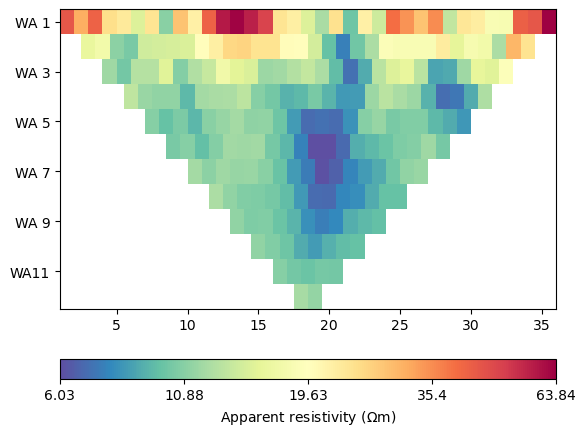

In [6]:
data2d = data.copy()  # pg.DataContainerERT(data)
xa = pg.x(data2d)[data2d["a"]]
xm = pg.x(data2d)[data2d["m"]]
data2d["valid"] = (xa == 220.) * (xm == 220.)
data2d.removeInvalid()
data2d.removeUnusedSensors()
data2d.swapXY()  # exchange x and y so that profile runs along x
data2d.show()

In [7]:
data.estimateError(relativeError=0.05, absoluteUError=50e-6)
mgr = ert.Manager(data)
mgr.invert(mesh=mesh, zWeight=0.2, verbose=True)
# mgr.saveResult()

28/08/23 - 11:14:24 - pyGIMLi - INFO - Found 2 regions.
28/08/23 - 11:14:24 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
28/08/23 - 11:14:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
28/08/23 - 11:14:26 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
28/08/23 - 11:14:29 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 38336 Cells: 196784 Boundaries: 208012
28/08/23 - 11:14:31 - pyGIMLi - INFO - Use median(data values)=11.029958607999644
28/08/23 - 11:14:31 - pyGIMLi - INFO - Created startmodel from forward operator: 20703, min/max=11.029959/11.029959
28/08/23 - 11:14:31 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x0000020151106310>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000002013F3791D0>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000002014EAB69A0>
min/max (data): 4.84/201
min/max (error): 5%/6.52%
min/max (start model): 11.03/11.03
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 24.68 (dPhi = 81.24%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 10.36 (dPhi = 54.54%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 5.75 (dPhi = 36.32%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 4.23 (dPhi = 18.55%) lam: 20.0
-----------------------------------

20703 [79.18546888337605,...,69.51598653710946]

In [11]:
pd = mgr.paraDomain
print(pd)
pd["res"] = mgr.model
pl, _ = pg.show(pd, label="res", style="surface",
                filter={"threshold": dict(value=20, scalars="res", method="upper")}, 
                cMap="Spectral_r", cMin=4, cMax=40, logScale=True, hold=True, notebook=True, backend="trame")
pv.drawMesh(pl, pd, label="res", style="surface",
            filter={"threshold": dict(value=6, scalars="res", method="lower")}, 
            cMap="Spectral_r", cMin=4, cMax=40, logScale=True, hold=True)
pl.camera_position = "xz"
pl.camera.azimuth = +50
pl.camera.elevation = 25
pl.camera.zoom(1.4)
_ = pl.show()

Mesh: Nodes: 4808 Cells: 20703 Boundaries: 5522


Widget(value="<iframe src='http://localhost:59357/index.html?ui=P_0x202a2ee5c40_4&reconnect=auto' style='width…

![Inversion result](screenshot.png)